In [2]:
import cv2
import pickle
import torch, torchvision
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from pathlib import Path
from matplotlib import pyplot as plt
import os
import torch.nn as nn

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
N_FRAME = 15
PATH_TO_VIDEO = 'source.mp4'
PATH_TO_DATASET = 'images/'
RESCALE_SIZE = (116, 116)
X_MIN, Y_MIN = 115, 210
X_MAX, Y_MAX = 350, 445

# Захват каждой 15 картинки

<font size = 4> Данная часть была сделана локально, чтобы удобно было размечать картинки. Поэтому пути не "кэгловские" </font>

In [ ]:
capture = cv2.VideoCapture(PATH_TO_VIDEO)

counter = 0
while capture.isOpened():
    grabbed, frame = capture.read()
    if grabbed:
        frame = frame[X_MIN : X_MAX, Y_MIN : Y_MAX]
        frame = cv2.resize(frame, RESCALE_SIZE, interpolation=cv2.INTER_CUBIC)

        if counter % N_FRAME == 0:
            frame_name = PATH_TO_DATASET + str(counter) + '.jpg'
            cv2.imwrite(frame_name, frame)
            print(frame_name, ' SAVED')
        counter += 1
    
    else:
        capture.release()
        break

In [5]:
DATA_MODES = ['train', 'val', 'test']
# выбрал новый размер 128, так как его удобнее считать в свёртках, а в задании ничего про это сказано не было
# картинки изначально вырезаны в размере 116
RESCALE_SIZE = (128, 128)
DEVICE = torch.device("cuda")
N_CLASSES = 2

# Построение датасета

In [22]:
class OfficeDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит и превращение в torch тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = {
            'train': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform[self.mode](x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        # наставляет паддинг, чтобы не изменялись пропорции изображения
        image = image.resize(RESCALE_SIZE)
        return np.array(image)

In [ ]:
TRAIN_DIR = Path('../input/office/images')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_files

In [24]:
from sklearn.model_selection import train_test_split
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [25]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

In [26]:
print(pd.Series(train_labels).value_counts())

Empty    21711
Work      6552
dtype: int64


In [27]:
print(pd.Series(val_labels).value_counts())

Empty    7237
Work     2184
dtype: int64


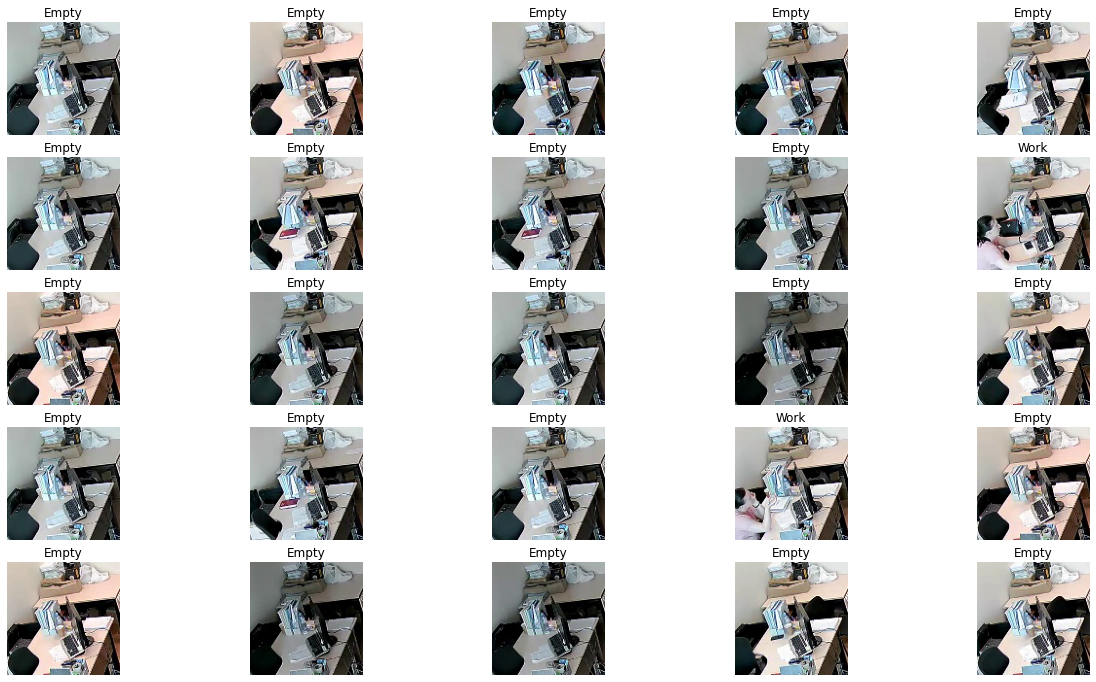

In [28]:
fig, axes = plt.subplots(5, 5, figsize=(21, 12))
rand_arr = [np.random.randint(0, len(train_files)) for i in range(25)]
for i in range(5):
    for j in range(5):
        img = plt.imread(train_files[rand_arr[5 * i + j]])
        axes[i][j].imshow(img)
        axes[i][j].axis('off')
        axes[i][j].set_title(train_labels[rand_arr[5 * i + j]])

# Простая модель

In [41]:
# BatchNorm befor activation
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        #input size 3 * 116 * 116
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #input size 8 * 57 * 57
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #input size 16 * 27 * 27
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #input size 32 * 12 * 12
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #input size 64 * 6 * 6
        self.out = nn.Linear(64 * 6 * 6, N_CLASSES)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [30]:
def fit_epoch(model, train_loader, criterion, optimizer, lr_sched):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    if lr_sched is not None:
        lr_sched.step()

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [31]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = float((running_corrects.double() / processed_size).cpu().numpy())
    return val_loss, val_acc

In [32]:
def train(train_files, val_files, model, epochs, batch_size, opt, lr_sched=None):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=True)

    history = []
    max_val_acc = 0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, lr_sched)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            #save the best weights
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                torch.save(model.state_dict(), "MyBestModel.pth")
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [33]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [34]:
def plot_loss(loss, val_loss):
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [43]:
def plot_acc(acc, val_acc):
    plt.figure(figsize=(15, 9))
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="val_acc")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.grid()
    plt.show()

In [42]:
train_dataset = OfficeDataset(train_files, mode='train')
val_dataset = OfficeDataset(val_files, mode='val')

model1 = SimpleCnn(N_CLASSES).to(DEVICE)
history_adam = train(train_dataset, val_dataset, model=model1, epochs=3, batch_size=64, opt=torch.optim.Adam(model1.parameters()))

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.028636559913381005


epoch:  33%|███▎      | 1/3 [03:12<06:24, 192.42s/it]


Epoch 001 train_loss: 0.0286     val_loss 0.0053 train_acc 0.9899 val_acc 0.9985
loss 0.006613088529355838


epoch:  67%|██████▋   | 2/3 [04:58<02:21, 141.84s/it]


Epoch 002 train_loss: 0.0066     val_loss 0.0037 train_acc 0.9984 val_acc 0.9989
loss 0.005833233239261336


epoch: 100%|██████████| 3/3 [06:44<00:00, 134.71s/it]


Epoch 003 train_loss: 0.0058     val_loss 0.0263 train_acc 0.9987 val_acc 0.9906


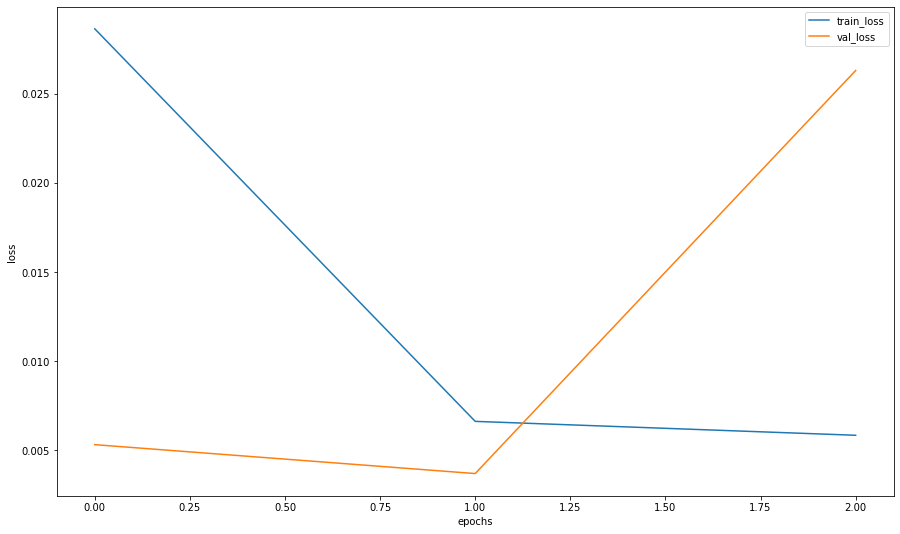

In [46]:
train_loss, train_acc, val_loss, val_acc = zip(*history_adam)
plot_loss(train_loss, val_loss)

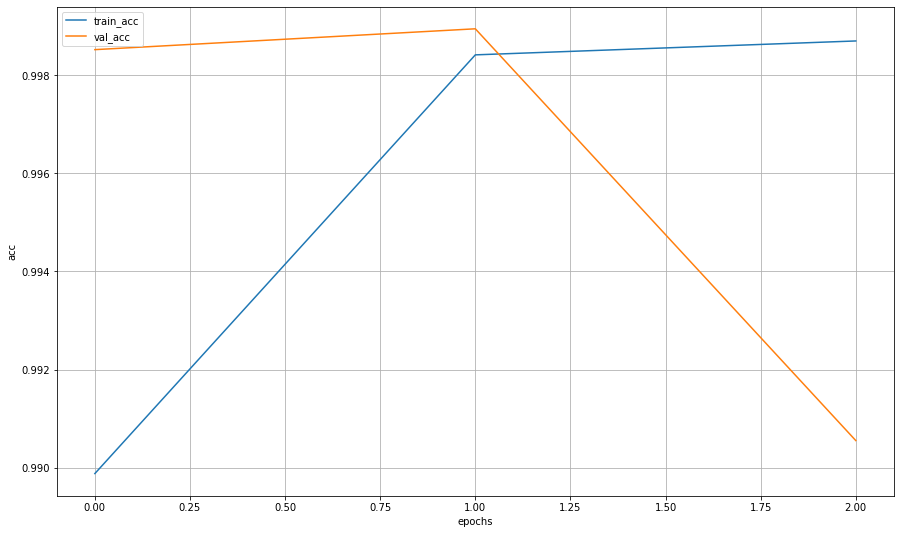

In [47]:
plot_acc(train_acc, val_acc)

# Инференс классификатора

In [66]:
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))

In [63]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [61]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

<font size = 5> Красным на картинке указано предсказание модели </font>

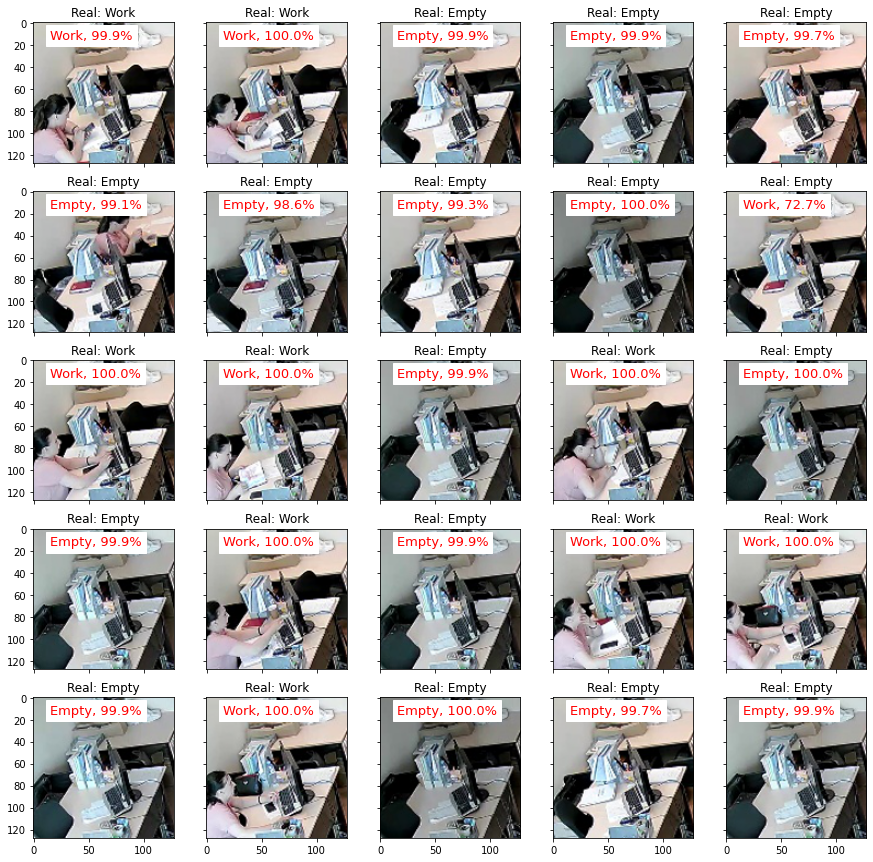

In [88]:
fig, ax = plt.subplots(5, 5,figsize=(15, 15), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(val_files)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)
    
    prob_pred = predict_one_sample(model1, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    
    fig_x.set_title(f'Real: {img_label}')
    fig_x.text(15, 15, f'{predicted_label}, {predicted_proba:.1f}%', c='r', fontsize=13, backgroundcolor='w')

# ИТОГ
<font size = 4> Модель можно еще пообучать, но так как задание тестовое, думаю accuracy > 0.99 достаточно. Да, классы не очень сбаллансированы (0.7 empty против 0.3 working) и стоило бы посмотреть на точность, полноту и f1 меру, но, опять же, это работа не для тестового задание(+ в требованиях ничего не было сказано) </font>